# 3장 사이킷런 알고리즘
## 앙상블모델(Ensemble model)

In [1]:
# 명령 결과 모두 보기
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 버전 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 판다스와 넘피
import pandas as pd
import numpy as np

# 그림 그리기
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

# 자료 스케일링
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 모델 선택
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# 성능지표
from sklearn.metrics import accuracy_score, plot_roc_curve 
from sklearn.metrics import plot_confusion_matrix, classification_report

# 파이프라인
from sklearn.pipeline import Pipeline, make_pipeline

# 시각화 툴
import scikitplot as skplt

# 모델저장
from joblib import dump, load

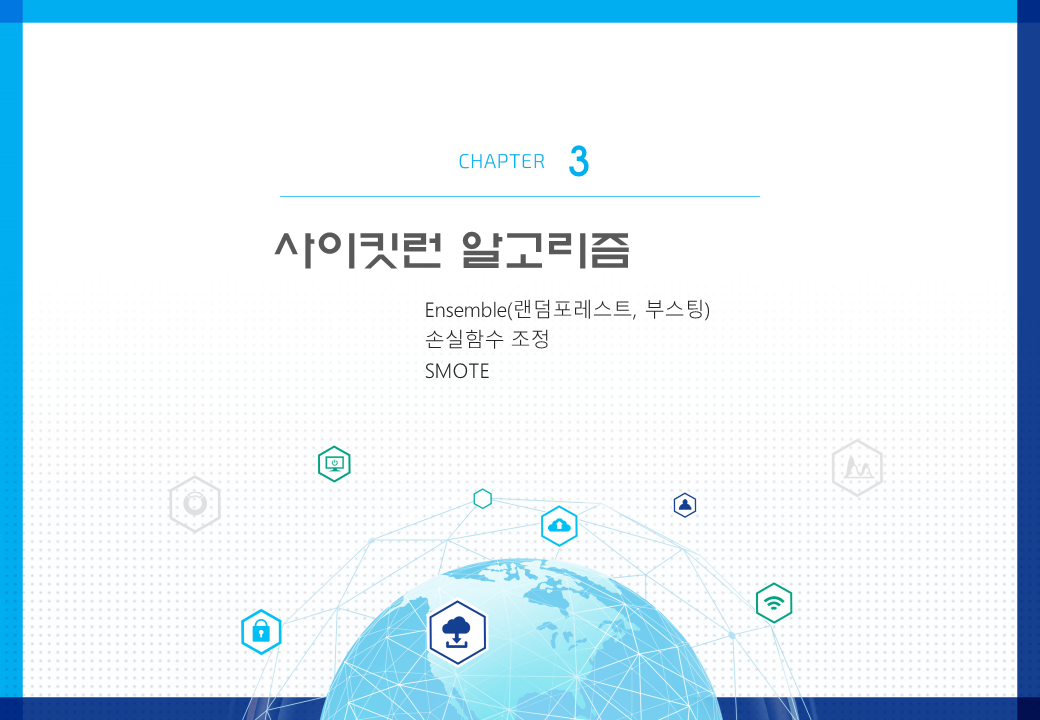

In [2]:
from IPython.display import Image
width = 800; height = 600
Image(filename='../img/슬라이드78.png', width=width, height=height)

## 배심원정리(Condorcet's jury theorem)

<Figure size 1080x432 with 0 Axes>

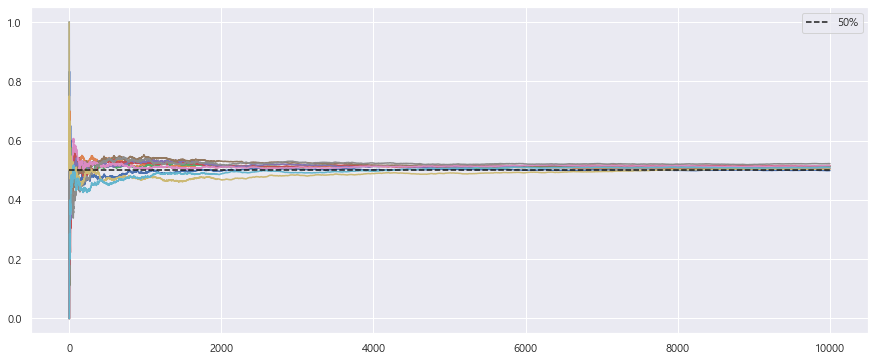

In [3]:
jurors_proba = 0.51
num_jurors = 10; num_trals = 10000 
num_decisions=(np.random.rand(num_trals, num_jurors)<jurors_proba)*1
total_trials = np.arange(1, num_trals+1).reshape(-1, 1)
cum_right_ratio=np.cumsum(num_decisions, axis=0)/total_trials
plt.figure(figsize=(15,6)); plt.plot(cum_right_ratio)
plt.plot([0, num_trals], [0.5, 0.5], 'k--', label='50%')
plt.legend(loc='higher right')

## Bootstrap
#### 표본(sample)에서 부트스트래핑 추출 회수를 늘리면 신뢰구간이 좁아지고 중심극한 정리에 따른다.
표본의 추출 개수가 아주 적은 경우 표본이 정규분포를 따른다고 가정할 수 없다.
표본을 resampling한 부트스트래핑은 중심극한 정리에 따라 샘플의 수가 증가하게 되어 정규분포를 따른다고 가정하면
각종 통계량 분석이 가능

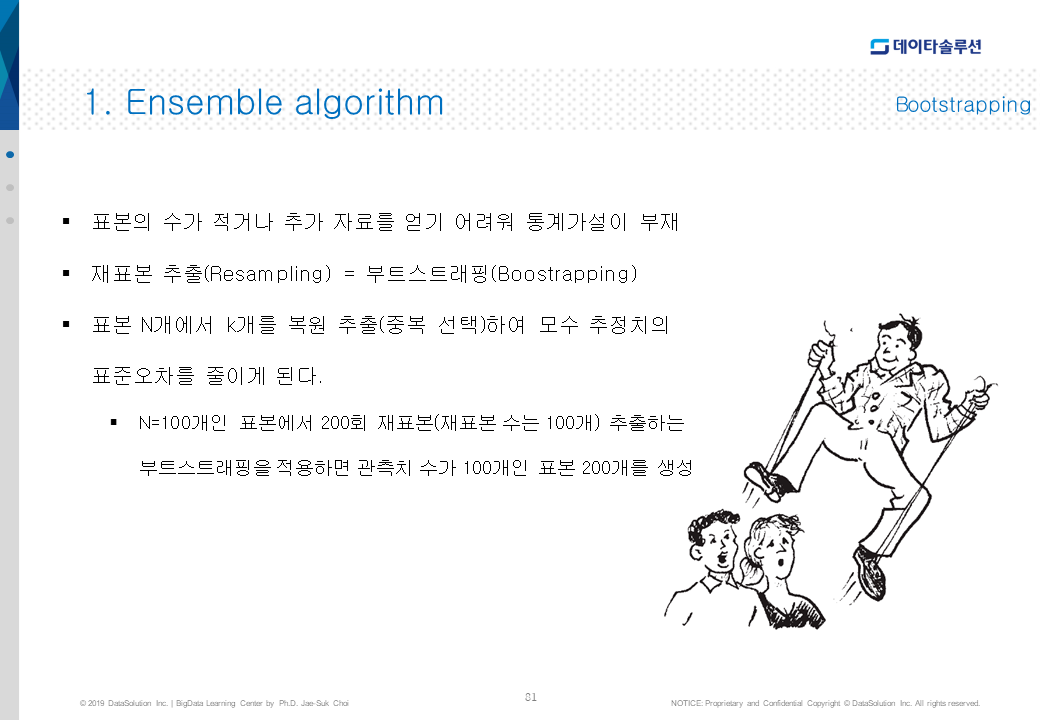

In [4]:
Image(filename='../img/슬라이드81.png', width=width, height=height)

In [6]:
n = 10000
trials = 10000
print(f'1 회 비복원추출시 뽑힐 확률은 {1/n}')
print(f'1 회 비복원추출시 안 뽑힐 확률은 {(1-1/n)}')
print(f'{trials}번 비복원 추출시 계속 안 뽑힐 확률은 {(1-1/n)**trials}')

1 회 비복원추출시 뽑힐 확률은 0.0001
1 회 비복원추출시 안 뽑힐 확률은 0.9999
10000번 비복원 추출시 계속 안 뽑힐 확률은 0.36786104643297046


### 신뢰구간과 bootstrapping (중심극한 정리, Central Limit Theorem)

1 부터 100까지 순번을 가진 자료 모집단에서, 20개를 표본추출
모집단_평균50.5, 표본_평균47.55
부트스트랩 샘플 20개로, 2000번 재표본_평균 47.5161


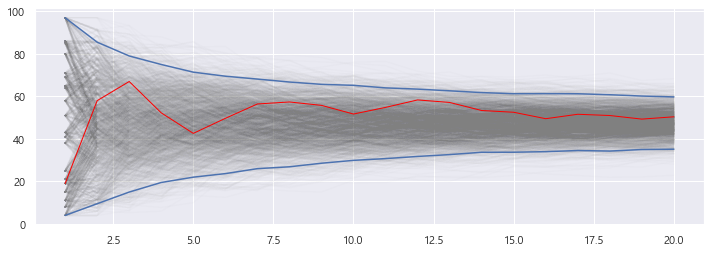

In [7]:
n =100; population = np.arange(1,n+1)# population size
sample = np.random.choice(population, (1, int(n/5)), replace=False)
sample, sample.mean()
repetitions = 2000 # 복원추출 회수(반복 회수)
select_num = int(n/5) # 복원추출 재표본 개수
boost = np.random.choice(np.squeeze(sample), 
                         (select_num, repetitions), replace=True)
print(f'1 부터 {n}까지 순번을 가진 자료 모집단에서, {int(n/5)}개를 표본추출')
print(f'모집단_평균{population.mean()}, 표본_평균{sample.mean()}')
print(f'부트스트랩 샘플 {select_num}개로, {repetitions}번 재표본_평균 {boost.mean()}')

yb = 1/np.arange(1, select_num+1)[:, None] * np.cumsum(boost, axis=0)
plt.figure(figsize=(12,4))
upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)
plt.plot(np.arange(1, select_num+1)[:, None], yb, c='grey', alpha=0.02)
plt.plot(np.arange(1, select_num+1), yb[:, 0], c='red', linewidth=1)
plt.plot(np.arange(1, select_num+1), upper, 'b',#
         np.arange(1, select_num+1), lower, 'b');

In [8]:
'''
boost.shape
pd.DataFrame(boost).head(3)
pd.DataFrame(np.cumsum(boost, axis=0)).head(3)
yb.shape
pd.DataFrame(yb).head(3)
'''

'\nboost.shape\npd.DataFrame(boost).head(3)\npd.DataFrame(np.cumsum(boost, axis=0)).head(3)\nyb.shape\npd.DataFrame(yb).head(3)\n'

# 병렬 결합

## Bagging 알고리즘

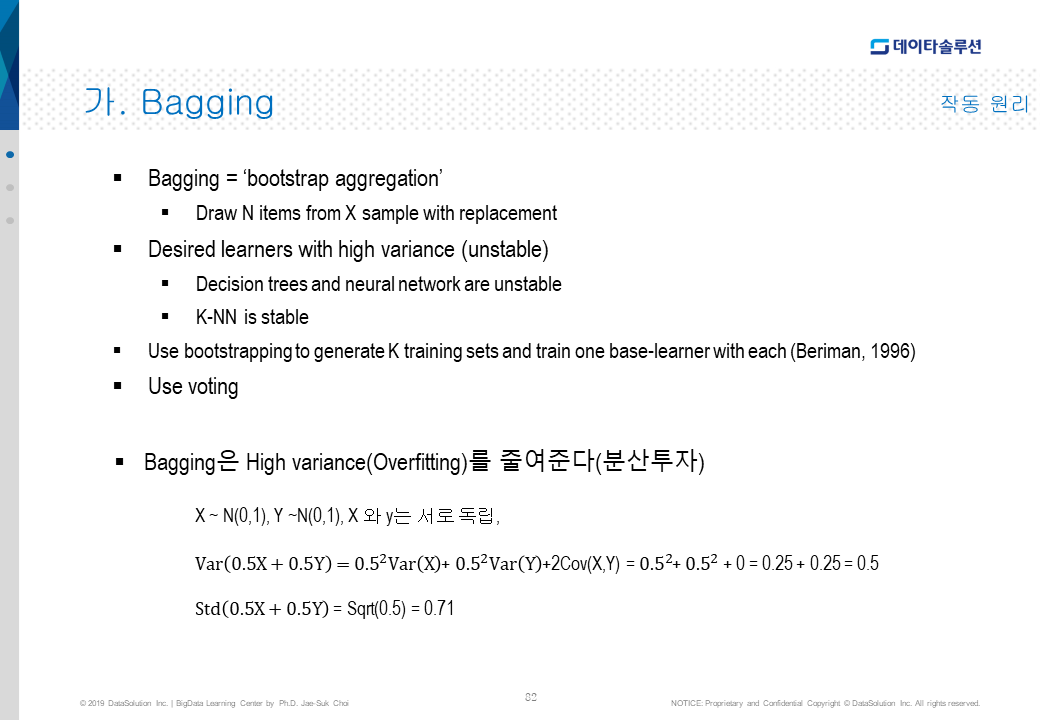

In [9]:
Image(filename='../img/슬라이드82.png', width=width, height=height)

## 데이터 불러오기

In [10]:
X = pd.read_pickle('../data/X.pkl') # 특성변수만 반영
y = pd.read_pickle('../data/y.pkl')
X.shape, y.shape
X.head()
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)
X_train.shape, X_test.shape
y_train.shape, y_test.shape

((4000, 78), (4000,))

,성별_1,성별_2,지역_1,지역_2,지역_3,지역_4,지역_5,지역_6,지역_7,직업_1,...,드라마_genre_7,드라마_genre_8,드라마_genre_9,드라마_genre_10,드라마_genre_11,드라마_genre_12,드라마_genre_13,드라마_genre_14,드라마_genre_15,드라마_genre_16
0,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.9375,0.875,0.0000,0.000,0.8125,0.0000,0.0,0.0
1,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0000,0.000,0.8750,0.000,0.0000,0.0000,0.0,0.0
2,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0000,0.000,0.0000,0.875,0.0000,0.8125,0.0,0.0
3,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.0
4,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0000,0.875,0.8125,0.000,0.0000,0.0000,0.0,0.0


((3200, 78), (800, 78))

((3200,), (800,))

### 1. Bagging과 랜덤포레스트

## □ Bagging

In [11]:
dt = load('../output/dt.joblib')

In [12]:
np.random.seed(1357)
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(dt, n_estimators = 30, max_samples =0.8)
y_predict = bag.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_predict)

0.68

In [13]:
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_predict))
confusion_matrix(y_test, y_predict, normalize='true').round(4)*100

              precision    recall  f1-score   support

           0       0.68      0.97      0.80       522
           1       0.71      0.13      0.22       278

    accuracy                           0.68       800
   macro avg       0.69      0.55      0.51       800
weighted avg       0.69      0.68      0.60       800



array([[97.13,  2.87],
       [86.69, 13.31]])

#### Stump(약한 분류기로 의사결정트리의 depth가 ‘1’)

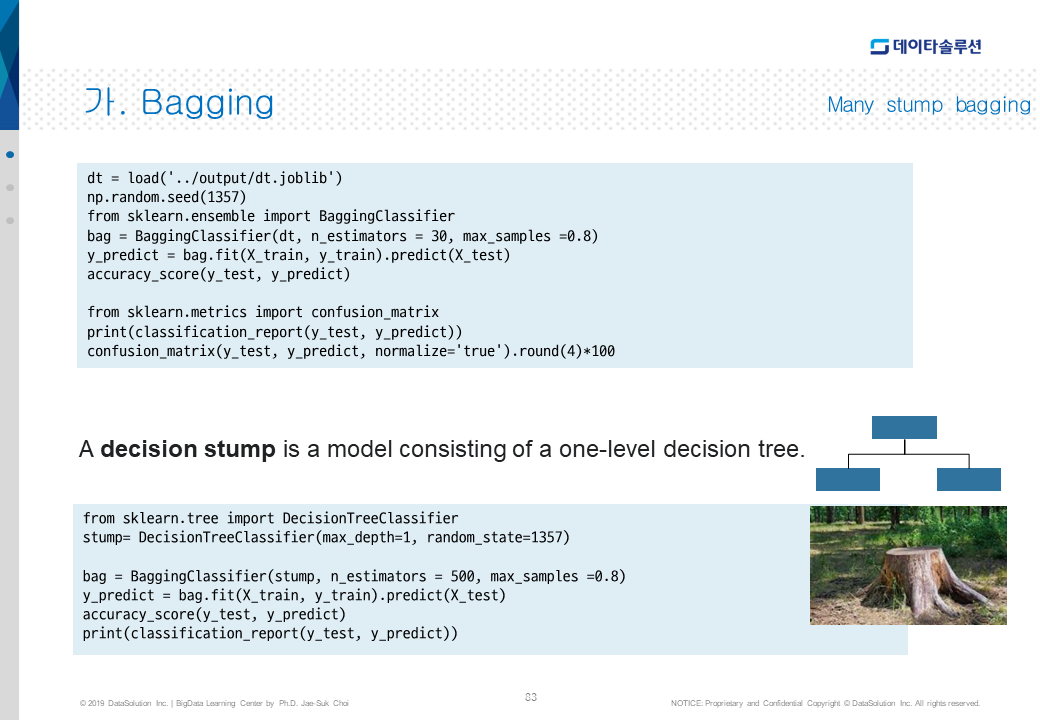

In [14]:
Image(filename='../img/슬라이드83.png', width=width, height=height)

In [15]:
from sklearn.tree import DecisionTreeClassifier
stump= DecisionTreeClassifier(max_depth=1, random_state=1357)

In [16]:
bag = BaggingClassifier(stump, n_estimators = 500, max_samples =0.8)
y_predict = bag.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_predict)
print(classification_report(y_test, y_predict))

0.6475

              precision    recall  f1-score   support

           0       0.67      0.89      0.77       522
           1       0.48      0.19      0.28       278

    accuracy                           0.65       800
   macro avg       0.58      0.54      0.52       800
weighted avg       0.61      0.65      0.60       800



In [17]:
BaggingClassifier().get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## □ 랜덤 포레스트

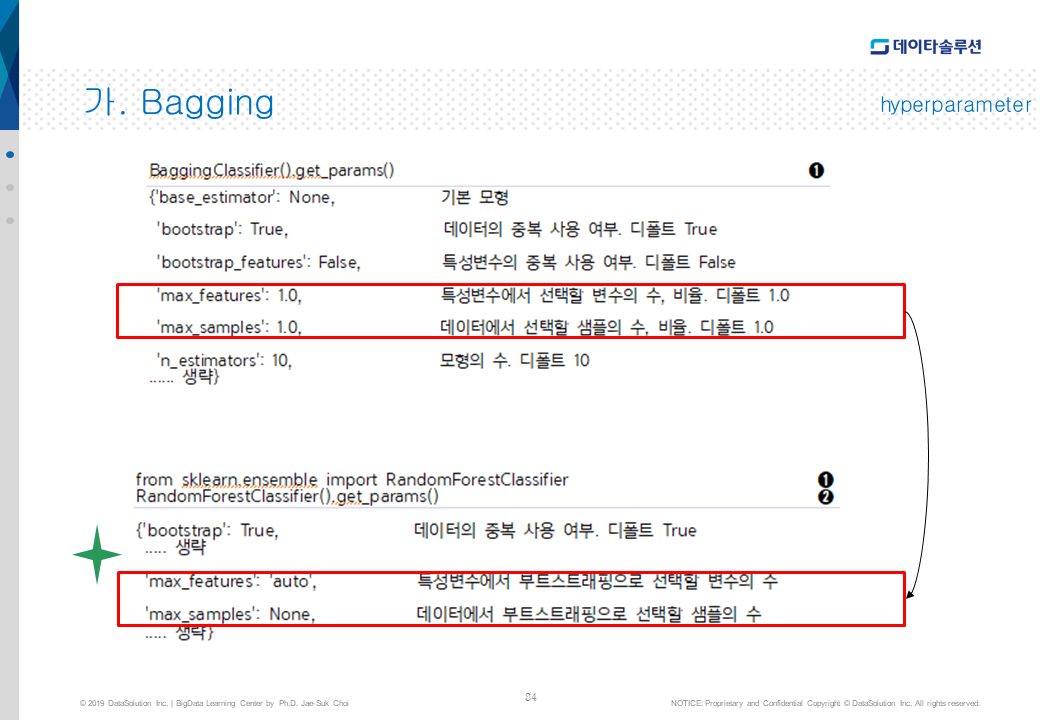

In [18]:
Image(filename='../img/슬라이드84.png', width=width, height=height)

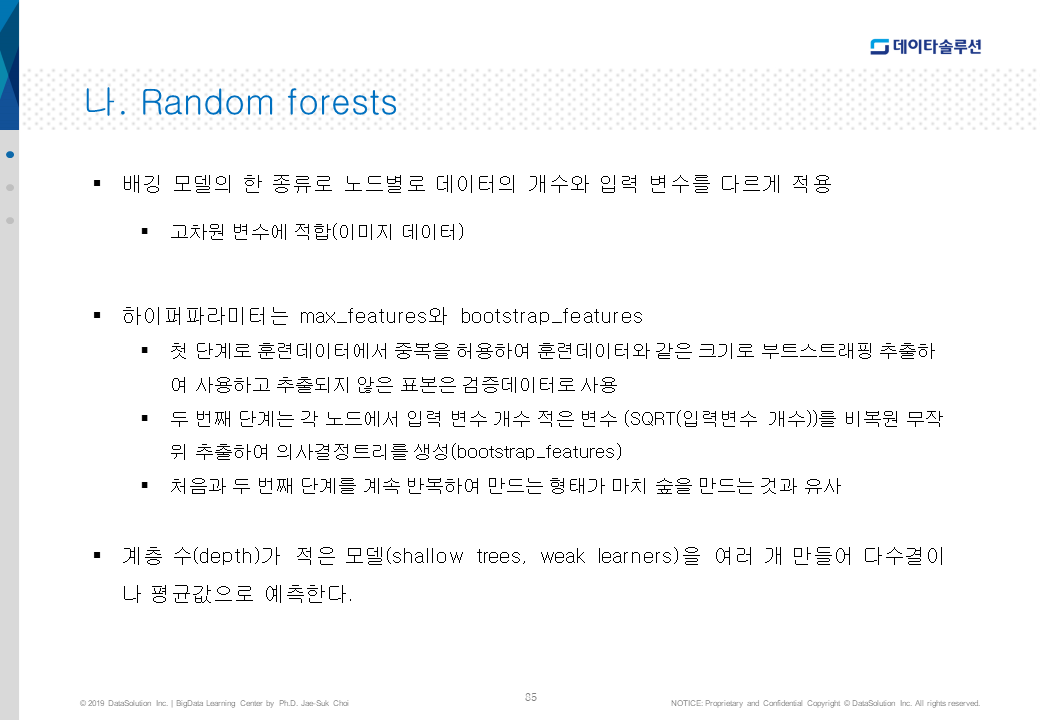

In [19]:
Image(filename='../img/슬라이드85.png', width=width, height=height)

In [20]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

max_samplesint or float, default=None
If bootstrap is True, the number of samples to draw from X to train each base estimator.

If None (default), then draw X.shape[0] samples.

In [21]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 20, 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [22]:
np.random.seed(4321)
kf = KFold(n_splits=5) 
rf = RandomForestClassifier(random_state=11)
rf_random = RandomizedSearchCV(rf, random_grid, cv=kf, scoring = 'recall_macro')
y_predict = rf_random.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_predict)

0.69375

In [23]:
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.71      0.91      0.79       522
           1       0.63      0.29      0.40       278

    accuracy                           0.69       800
   macro avg       0.67      0.60      0.60       800
weighted avg       0.68      0.69      0.66       800

[[473  49]
 [196  82]]


In [24]:
from sklearn.metrics import roc_auc_score, average_precision_score
y_proba = rf_random.predict_proba(X_test)
roc_auc_score(y_test, y_proba[:, 1])
average_precision_score(y_test, y_proba[:, 1])

0.6898756856583699

0.559513946711468

## □ OOB Error(Out of Bag Error)

- OOB(Out-of-bag) 오류는 각 부트스트랩 샘플에 포함되지 한 번도 추출되지 않은 자료로 예측의 적합성을 검사하기 위해 계산한 오류
- 분류기 300개로 OOB(300회 부트스트랩 샘플에 한 번도 추출되지 않은 자료에 대한 예측 정확도)를 설정한 랜텀포레스트로 예측

In [25]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=15, min_samples_leaf=4,
                       n_estimators=10, random_state=11)

In [26]:
rf = RandomForestClassifier(bootstrap=True, max_depth=15, min_samples_leaf=4,
                            n_estimators=300, oob_score=True, random_state=11)  # X_train.shape[0]개수 만큼 bootstrapping
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print(f'Mean accuracy score: {accuracy:.3}')
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')

RandomForestClassifier(max_depth=15, min_samples_leaf=4, n_estimators=300,
                       oob_score=True, random_state=11)

Mean accuracy score: 0.713
Out-of-bag score estimate: 0.709


## VotingClassifier()

In [27]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
np.random.seed(3567)

In [28]:
estimators=[('lgr', LogisticRegression(class_weight='balanced')),
            ('rf',  RandomForestClassifier(class_weight='balanced')),
            ('gnb', GaussianNB())]
eclf = VotingClassifier(estimators, voting='soft')
params = {}
grid = RandomizedSearchCV(eclf, params, cv = kf,  verbose = 1, n_iter = 20, scoring = 'f1_macro')                 
y_predict = grid.fit(X_train, y_train).predict(X_test)
y_proba = grid.fit(X_train, y_train).predict_proba(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished


              precision    recall  f1-score   support

           0       0.81      0.22      0.34       522
           1       0.38      0.91      0.54       278

    accuracy                           0.46       800
   macro avg       0.60      0.56      0.44       800
weighted avg       0.66      0.46      0.41       800



array([[114, 408],
       [ 26, 252]], dtype=int64)

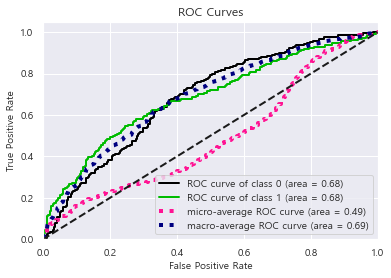

In [29]:
print(classification_report(y_test, y_predict))
confusion_matrix(y_test, y_predict)

skplt.metrics.plot_roc(y_test, y_proba)

## 2. 부스팅

## Adaboost

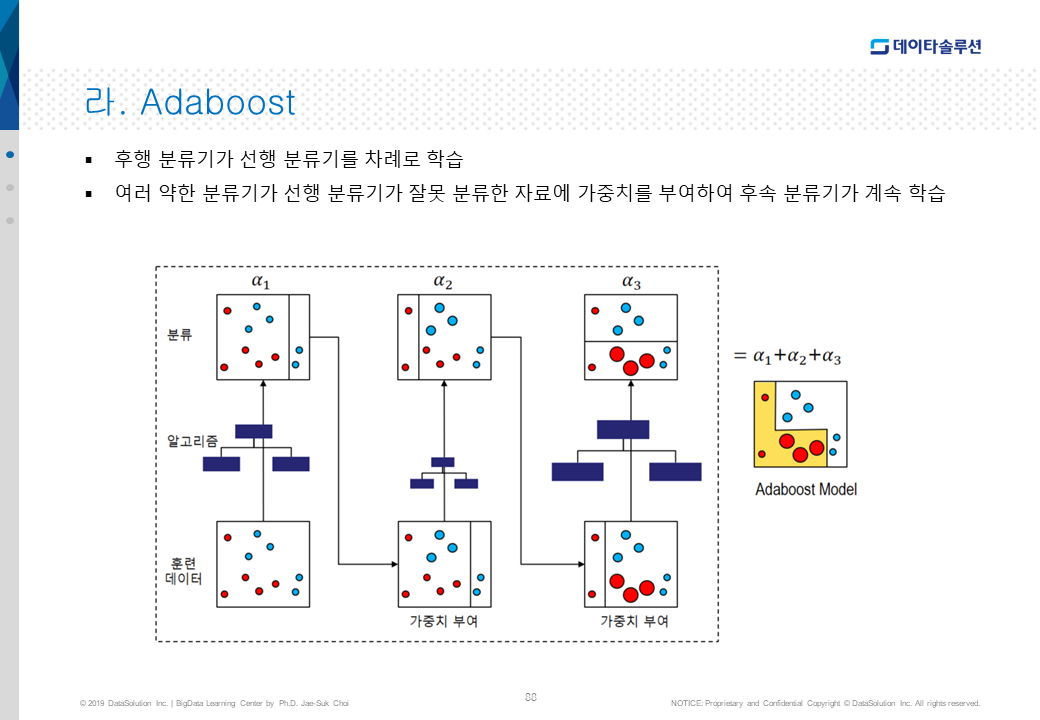

In [30]:
Image(filename='../img/슬라이드88.png', width=width, height=height)

In [31]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,
                             algorithm="SAMME.R", 
                             learning_rate=0.05, random_state=1357)
y_predict = ada_clf.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_predict)

0.6575

In [32]:
print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict))
y_proba = ada_clf.predict_proba(X_test)
roc_auc_score(y_test, y_proba[:, 1])
average_precision_score(y_test, y_proba[:, 1])

[[476  46]
 [228  50]]
              precision    recall  f1-score   support

           0       0.68      0.91      0.78       522
           1       0.52      0.18      0.27       278

    accuracy                           0.66       800
   macro avg       0.60      0.55      0.52       800
weighted avg       0.62      0.66      0.60       800



0.6452596543454892

0.4864018220417229

## GBM(Gradient Boosting)

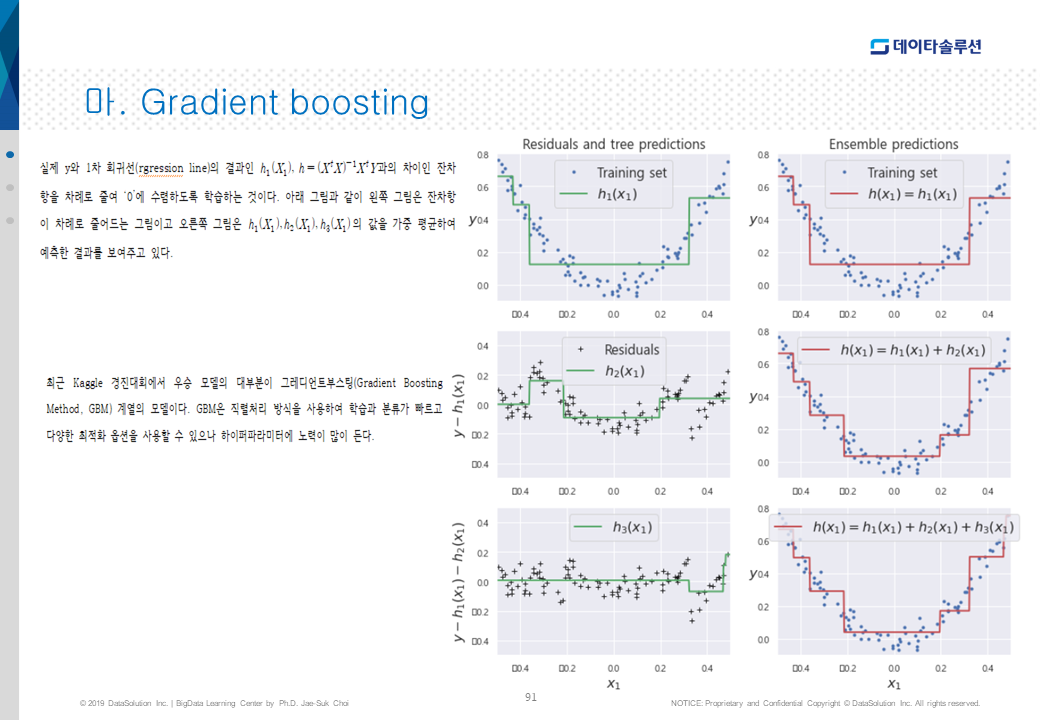

In [33]:
Image(filename='../img/슬라이드91.png', width=width, height=height)

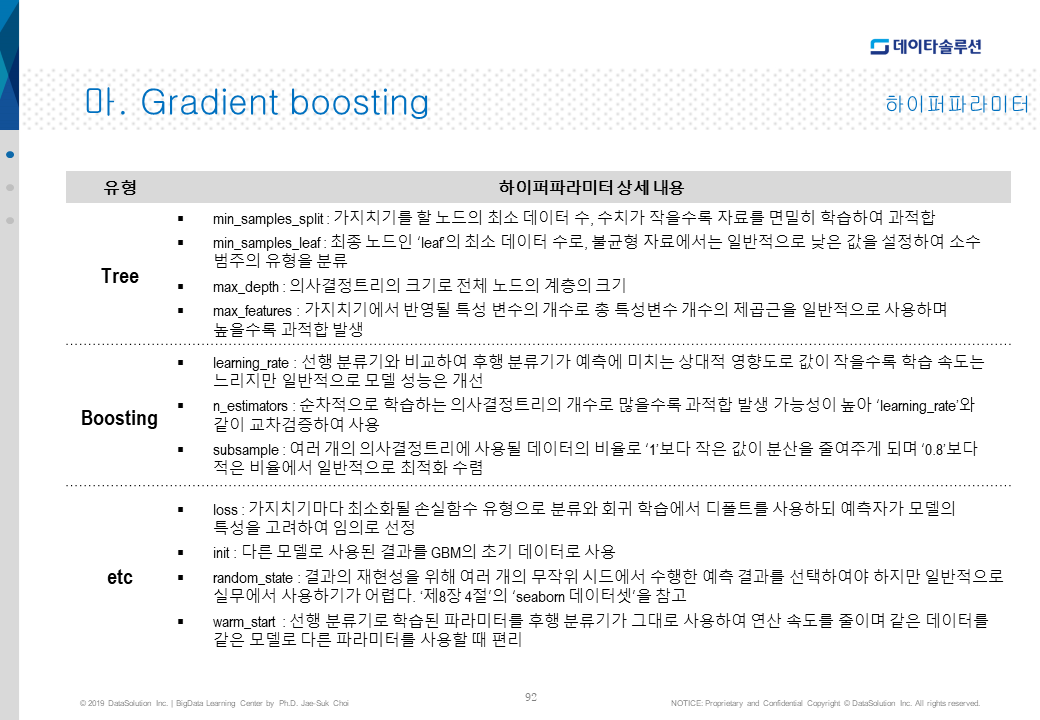

In [34]:
Image(filename='../img/슬라이드92.png', width=width, height=height)

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
np.random.seed(9753)

classifiers = {}
classifiers.update({'Random Forest': RandomForestClassifier()})
classifiers.update({'Gradient Boosting': GradientBoostingClassifier()})
classifiers

{'Random Forest': RandomForestClassifier(),
 'Gradient Boosting': GradientBoostingClassifier()}

In [36]:
parameters = {}
parameters.update({'Random Forest': 
{ 
'classifier__n_estimators': [50, 100, 150, 200, 250, 300],
'classifier__class_weight': [None, 'balanced'],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__max_depth' : [int(x) for x in np.linspace(5, 20, 10)],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
'classifier__criterion' :['gini', 'entropy']     ,
'classifier__n_jobs': [-1]
}})

In [37]:
parameters.update({'Gradient Boosting': 
{ 
'classifier__learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 
'classifier__n_estimators': [200],
'classifier__max_depth': [2,3,4,5,6],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__subsample': [0.8, 0.9, 1]
}})

In [38]:
from sklearn.metrics import f1_score, recall_score, log_loss
from sklearn.metrics import brier_score_loss, matthews_corrcoef

In [39]:
results = {}
for classifier_label, classifier in classifiers.items():
    steps = [ ('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = parameters[classifier_label]
    grid = RandomizedSearchCV(pipeline, param_grid, cv = kf,  n_jobs= -1,
                          n_iter = 5,
                          scoring = 'recall_macro')  
    
    y_pred = grid.fit(X_test, y_test).predict(X_test)
    y_proba = grid.fit(X_test, y_test).predict_proba(X_test)
    y_score = y_proba[:,1]
    
    print('*'*50); print('Classifier name : ', classifier_label )
    print(classification_report(y_test, y_pred))
    
    result = {#'Classifier': classifier_label,
              'Best Parameters': grid.best_params_,
              'Recall_macro': recall_score(y_test, y_pred, average='macro'),
              'AUROC' : roc_auc_score(y_test, y_score),
              'Mean PR': average_precision_score(y_test, y_score),
              'F1-score': f1_score(y_test, y_pred),
              'Accuracy': accuracy_score(y_test, y_pred),
              'Log_loss': log_loss(y_test, y_proba),
              'Brier_scor': brier_score_loss(y_test, y_proba[:,1]),
              'MC': matthews_corrcoef(y_test, y_pred)
             }
    
    results.update({classifier_label: result})
    dump(grid.fit(X_train, y_train), '../output/' + classifier_label + '.joblib')

**************************************************
Classifier name :  Random Forest
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       522
           1       0.78      0.79      0.79       278

    accuracy                           0.85       800
   macro avg       0.84      0.84      0.84       800
weighted avg       0.85      0.85      0.85       800



['../output/Random Forest.joblib']

**************************************************
Classifier name :  Gradient Boosting
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       522
           1       0.95      0.72      0.82       278

    accuracy                           0.89       800
   macro avg       0.91      0.85      0.87       800
weighted avg       0.90      0.89      0.89       800



['../output/Gradient Boosting.joblib']

In [40]:
pd.DataFrame(results).T

,Best Parameters,Recall_macro,AUROC,Mean PR,F1-score,Accuracy,Log_loss,Brier_scor,MC
Random Forest,"{'classifier__n_jobs': -1, 'classifier__n_esti...",0.837254,0.871517,0.808528,0.78712,0.85125,0.566889,0.188835,0.672835
Gradient Boosting,"{'classifier__subsample': 0.8, 'classifier__n_...",0.850134,0.983117,0.974373,0.819672,0.89,0.271732,0.0723328,0.757855


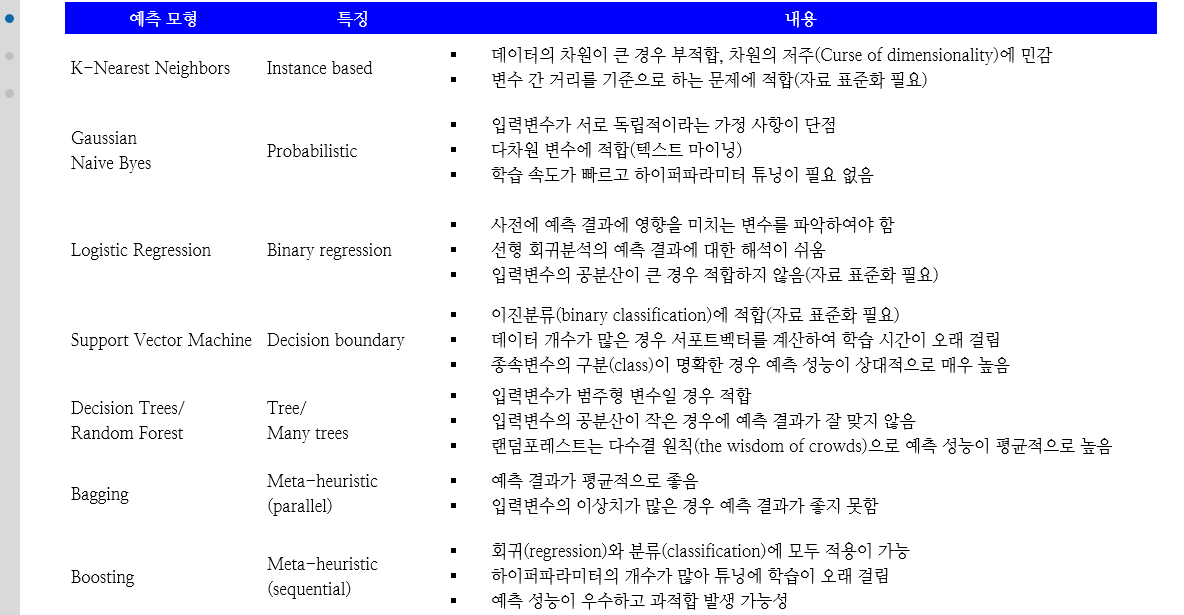

In [41]:
Image(filename='../img/summary.png', width=1000, height=500)

#  <font color='red'> END

## <font color='brown'> 강의 설명 자료

In [42]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

DecisionTreeRegressor(max_depth=2, random_state=42)

DecisionTreeRegressor(max_depth=2, random_state=42)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [43]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

<Figure size 792x792 with 0 Axes>

Text(0, 0.5, '$y$')

Text(0.5, 1.0, 'Residuals and tree predictions')

Text(0, 0.5, '$y$')

Text(0.5, 1.0, 'Ensemble predictions')

Text(0, 0.5, '$y - h_1(x_1)$')

Text(0, 0.5, '$y$')

Text(0, 0.5, '$y - h_1(x_1) - h_2(x_1)$')

Text(0.5, 0, '$x_1$')

Text(0.5, 0, '$x_1$')

Text(0, 0.5, '$y$')

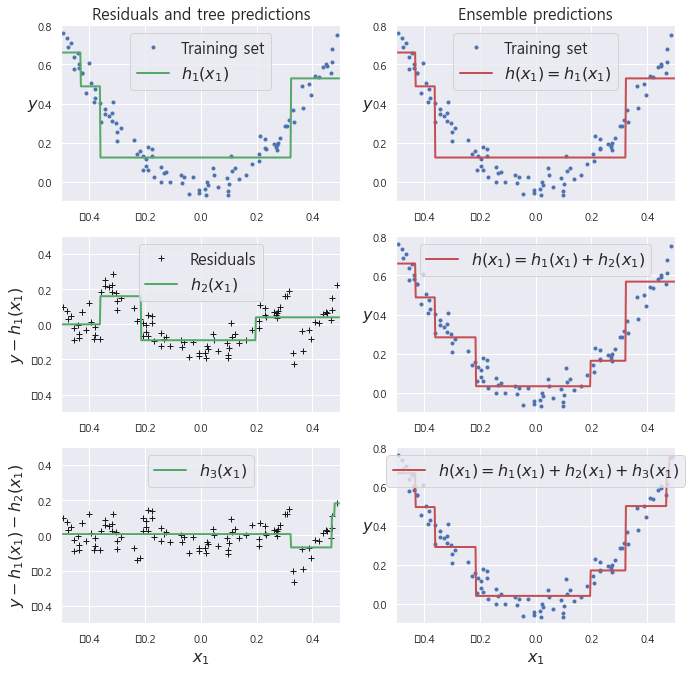

In [44]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [45]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [46]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Text(0.5, 1.0, 'learning_rate=1.0, n_estimators=3')

Text(0.5, 0, '$x_1$')

Text(0, 0.5, '$y$')

Text(0.5, 1.0, 'learning_rate=0.1, n_estimators=200')

Text(0.5, 0, '$x_1$')

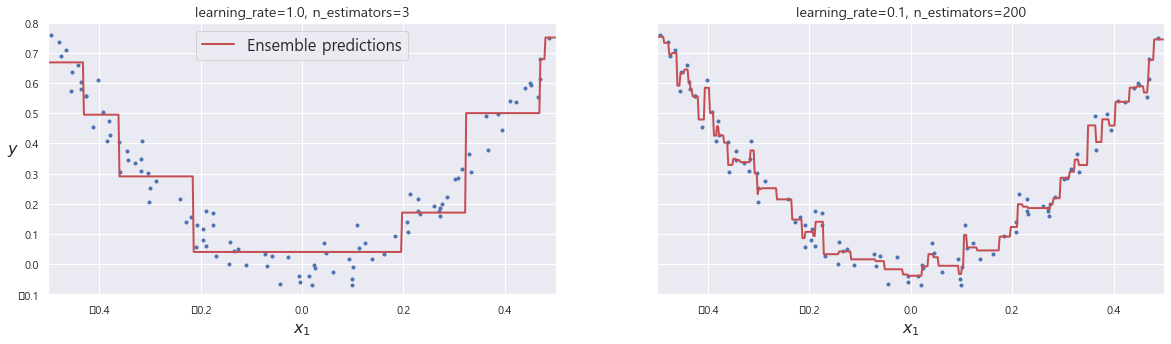

In [47]:
fix, axes = plt.subplots(ncols=2, figsize=(20,5), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

## Gradient Boosting with Early stopping

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [49]:
min_error = np.min(errors)

<Figure size 720x288 with 0 Axes>

Text(56, 0.0032554239902825555, 'Minimum')

(0.0, 120.0, 0.0, 0.01)

Text(0.5, 0, 'Number of trees')

Text(0, 0.5, 'Error')

Text(0.5, 1.0, 'Validation error')

Text(0.5, 1.0, 'Best model (56 trees)')

Text(0, 0.5, '$y$')

Text(0.5, 0, '$x_1$')

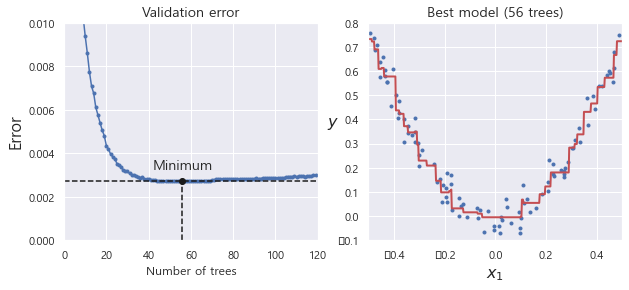

In [50]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()